In [1]:
import pandas as pd

import io
import os
import glob
import sys

# #get micronetworks package
sys.path.append(r'/home/ubuntu/baby_biome_functional02132023/micronetworks')
import micronetworks
from micronetworks.networkstats import *


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib




Much of the actual data names pertainign to files, taxa and metabolites has been removed due to proprietary data. But the approach shoudl be similar on your data set. I will output the header and first few rows of a file so you can get an idea of how to have your data wrangled prior to analysis. 

In [2]:
breast_metabol = pd.read_excel('Infant_Breast_Milk_Metabolomics_Worksheet.xlsx',sheet_name='Template')
breast_metabol = breast_metabol.add_prefix('PBT-0').rename(columns={'PBT-0Unnamed: 0':'metabolites'})
breast_metabol = breast_metabol.iloc[1:].set_index('metabolites').replace('nq', 0).replace('NQ', 0).T
breast_metabol[:1].iloc[:,:2]

metabolites,2-methylbutyrate,3-hydroxybenzoate
PBT-03005,0.0,0.0


In [3]:
 
    
all_other_samples = pd.read_excel('PR002-22A_Persephone_Feces_Microbiome_CDT_021323.xlsx',sheet_name='PR002A-23_Feces_Dry_weight_data')
all_other_samples = all_other_samples.drop(all_other_samples.columns[:11], axis=1)
all_other_samples = all_other_samples.drop(all_other_samples.index[:2])
all_other_samples = all_other_samples.add_prefix('PBT-0').rename(columns={'PBT-0Subject Name':'metabolites'})
all_other_samples = all_other_samples.set_index('metabolites').replace('nq', 0).replace('NQ', 0).T


all_other_samples[:1].iloc[:,:2]

metabolites,2-methylbutyrate,3-hydroxybenzoate
PBT-03010,612.502667,2.176833


In [5]:
# clr transform and use  multiplicative replacement 
breast_metabol = mr_clr(breast_metabol)
all_other_samples = mr_clr(all_other_samples)

In [6]:
metabolites_all = pd.concat([breast_metabol, all_other_samples]).drop_duplicates()


In [10]:
taxon = pd.read_csv('curated_abundances.tsv', sep='\t')

taxon = taxon[taxon['abundance']>=0.02]
print(taxon.shape)


(2672, 6)


In [11]:
tax_pivot = taxon.pivot_table(index='sample_id',values='abundance',columns='name')
tax_clr  =mr_clr(relativeabun(tax_pivot))
tax_ra = relativeabun(tax_pivot)

In [12]:
tax_metabolomics = pd.merge(tax_clr.reset_index(), metabolites_all.reset_index(), left_on='sample_id', right_on = 'index').drop(columns=['index']).set_index('sample_id')


# multiple regression

                            OLS Regression Results                            
Dep. Variable:            metabolite1   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     20.26
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           4.54e-13
Time:                        03:49:53   Log-Likelihood:                -204.20
No. Observations:                 139   AIC:                             418.4
Df Residuals:                     134   BIC:                             433.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4177      0.142      2.949      0.0

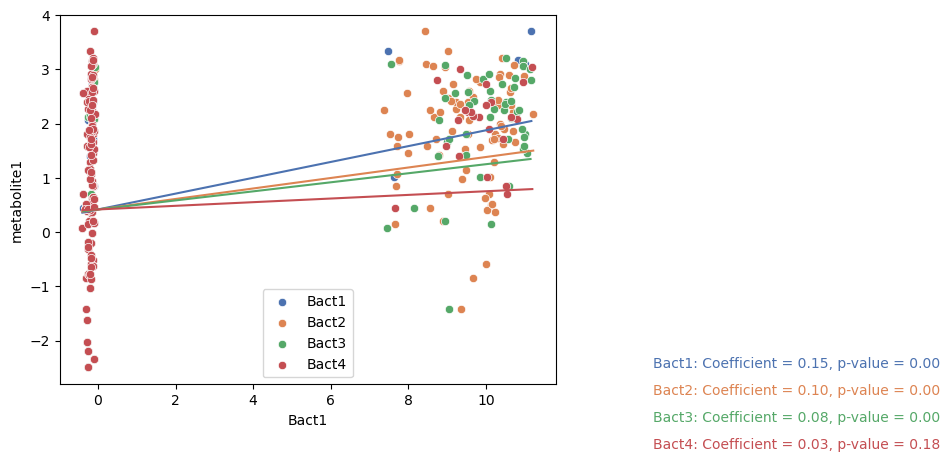

<Figure size 800x600 with 0 Axes>

In [17]:
regression_model = visualize_multiple_regression(['Bact1','Bact2','Bact3','Bact4'],'metabolite1', tax_metabolomics)

In [24]:

tax_pivot = taxon.pivot_table(index='sample_id',values='abundance',columns='name').fillna(0)
print(tax_pivot.shape)
    
tax_pivot = drop_feature_based_on_prevelance(tax_pivot,3)

tax_clr  =mr_clr(relativeabun(tax_pivot))

tax_metabolomics = pd.merge(tax_clr.reset_index(), metabolites_all.reset_index(), left_on='sample_id', right_on = 'index').drop(columns=['index']).set_index('sample_id')

print('Total metabolites and taxa :', str(tax_metabolomics.shape[0]))


(412, 294)
Number of total samples:  412
Number of total features in raw data:  294
Number of total features after filtering out based on prevalence less than  3 : 47
Total metabolites and taxa : 139


In [25]:
# corr matrix 
corr_matrix_tax_metabolomics = tax_metabolomics.corr()


In [26]:
# Get pearsons
tax_metabolomicso_pearson = calculate_corrcoef_pvalues(tax_metabolomics,pearsonr)  

In [27]:
# helps organize
tax_metabolomics_coeff_pval_corr = merge_corr_coef_pvalue_corr(tax_metabolomics,
                                                                         tax_metabolomicso_pearson,
                                                                         corr_coef=0, pval=1)

In [28]:
# inverse covariance glasso
full_inverse_cov_df, full_inverse_cov_netset = inverse_cov_glasso(tax_metabolomics,0.0,ncv=7,max_iterr=8880)


/home/ubuntu/anaconda3/envs/micronetworks/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


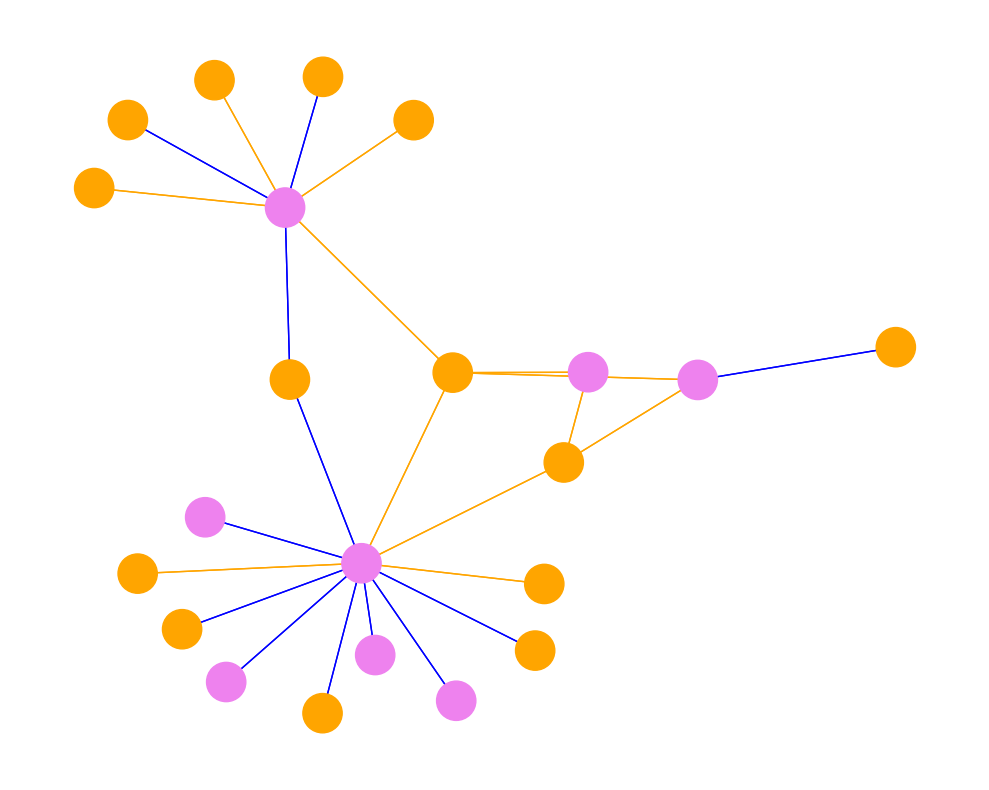

In [30]:
# what if we just wanted to focus on the above variables of interest

#variables we are filtering from 
corr_coef = 0.01
pval = 0.05
corr_matrix = corr_matrix_tax_metabolomics
pearson_r = tax_metabolomicso_pearson
inv_covaraince = full_inverse_cov_netset
taxanomic = tax_clr

metabolites = metabolites_all
### Prepare the correlation df
links = corr_matrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
links['absolute'] = abs(links['value'])

### Prepare the pvalues calcualted above
networkset = pearson_r.stack().reset_index()
networkset = networkset.loc[ (networkset['level_0'] != networkset['level_1'])]

### multiple comparisons pvalue adjustment. 
networkset['pvalue_corr'] = multipletests(networkset[0],
                                  alpha=0.05,
                                  method='fdr_bh',
                                  is_sorted=False,
                                  returnsorted=False)[1]

networkset.columns = ['var1', 'var2', 'pvalue','pvalue_corr']

### merge our correlation and pvalue df
networkset = pd.merge(networkset, links,  left_on=['var1','var2'], right_on = ['var1','var2'])

# subset our dataframe based on correlation coefficient, pvalue_corr (corrected for multiple test) and also remove self correlation (feature_a vs feature_a)
networkset = networkset.loc[ (networkset['absolute'] > corr_coef) & (networkset['var1'] != networkset['var2']) & (networkset['pvalue_corr']<= pval) ]

networkset_cov=inv_covaraince.loc[ (abs(inv_covaraince['value']) > 0) &  (inv_covaraince['var1'] != inv_covaraince['var2']) ]


# only focus on bacteria ofinterest
search_for = list(networkset_cov[(networkset_cov['var1']=="Bact1") | 
                                 (networkset_cov['var1']=="Bact2")| 
                                 (networkset_cov['var1']=="Bact3")| 
                                 (networkset_cov['var1']=="Bact4")]['var1'].unique())
                                 
networkset_cov = networkset_cov[(networkset_cov['var1'].str.contains('|'.join(search_for))) | (networkset_cov['var2'].str.contains('|'.join(search_for)))]
network_merged = pd.merge(networkset_cov,networkset, on=['var1','var2'])


nodes = list(network_merged['var1'].unique())
edges = [tuple(i) for i in network_merged[['var1','var2']].values]


# Change colors of edges depending of whether there is a negative correlation or  positive correlation
colors = network_merged['value_y'].apply(lambda x: 'blue' if x <0 else 'orange') 

#ADD COLORS TO THE FEATURE NODES
metabol = pd.DataFrame(metabolites.columns).rename(columns = {'metabolites':'features'})
tax = pd.DataFrame(taxanomic.columns).rename(columns = {'name':'features'})

metabol['type']='metabolite'
tax['type']='taxa'

multi_omics_feature_info = pd.concat([metabol,tax])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'violet' if x == 'taxa' else ('orange' if x=='metabolite' else 'orange')) 


G=nx.from_pandas_edgelist(network_merged, 'var1', 'var2',edge_attr='value_x')

fig, ax = plt.subplots(figsize=(10, 8))
     
nx.draw(G,edgelist = edges, nodelist=nodes,  node_color=node_colors,node_size=800, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.2))
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.tight_layout()
plt.show()

I removed the labels above due to the sensitivity of the data, but you can always just change the nx.draw to the following:
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True,   node_color=node_colors,node_size=800, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.2))


# full network and modules

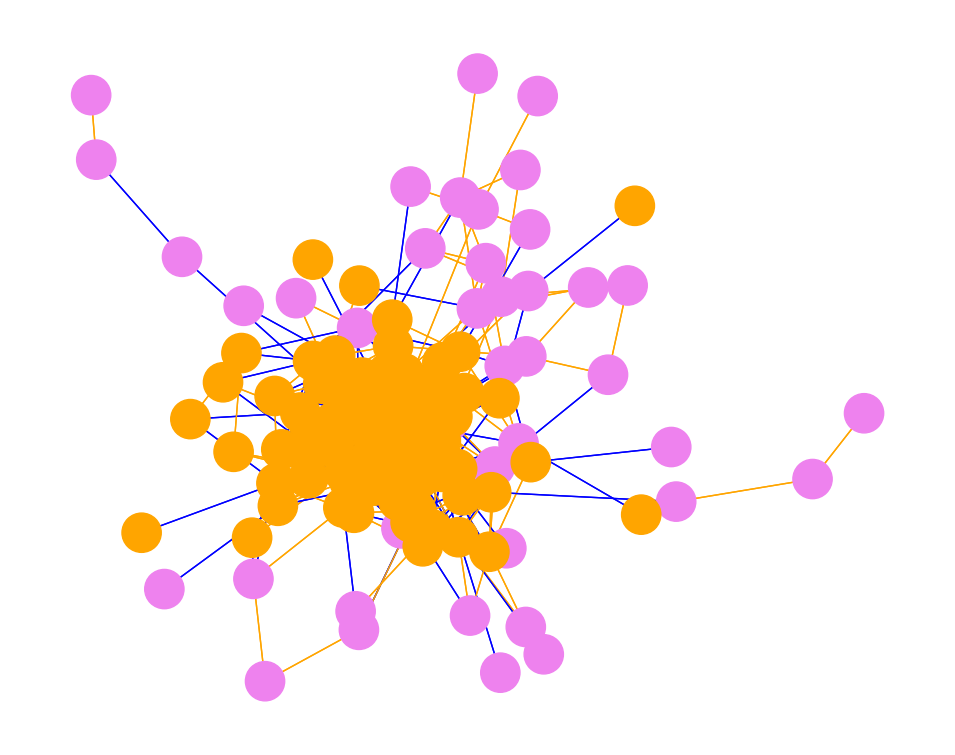

In [36]:

#variables we are filtering from 
corr_coef = 0.01
pval = 0.05
corr_matrix = corr_matrix_tax_metabolomics
pearson_r = tax_metabolomicso_pearson
inv_covaraince = full_inverse_cov_netset
taxanomic = tax_clr

metabolites = metabolites_all
### Prepare the correlation df
links = corr_matrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
links['absolute'] = abs(links['value'])

### Prepare the pvalues calcualted above
networkset = pearson_r.stack().reset_index()
networkset = networkset.loc[ (networkset['level_0'] != networkset['level_1'])]

### multiple comparisons pvalue adjustment. 
networkset['pvalue_corr'] = multipletests(networkset[0],
                                  alpha=0.05,
                                  method='fdr_bh',
                                  is_sorted=False,
                                  returnsorted=False)[1]

networkset.columns = ['var1', 'var2', 'pvalue','pvalue_corr']

### merge our correlation and pvalue df
networkset = pd.merge(networkset, links,  left_on=['var1','var2'], right_on = ['var1','var2'])

# subset our dataframe based on correlation coefficient, pvalue_corr (corrected for multiple test) and also remove self correlation (feature_a vs feature_a)
networkset = networkset.loc[ (networkset['absolute'] > corr_coef) & (networkset['var1'] != networkset['var2']) & (networkset['pvalue_corr']<= pval) ]

networkset_cov=inv_covaraince.loc[ (abs(inv_covaraince['value']) > 0) &  (inv_covaraince['var1'] != inv_covaraince['var2']) ]

network_merged = pd.merge(networkset_cov,networkset, on=['var1','var2'])


nodes = list(network_merged['var1'].unique())
edges = [tuple(i) for i in network_merged[['var1','var2']].values]


# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = network_merged['value_y'].apply(lambda x: 'blue' if x <0 else 'orange') 

##ADD COLORS TO THE FEATURE NODES
metabol = pd.DataFrame(metabolites.columns).rename(columns = {'metabolites':'features'})
tax = pd.DataFrame(taxanomic.columns).rename(columns = {'name':'features'})

metabol['type']='metabolite'
tax['type']='taxa'

multi_omics_feature_info = pd.concat([metabol,tax])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'violet' if x == 'taxa' else ('orange' if x=='metabolite' else 'orange')) 

G=nx.from_pandas_edgelist(network_merged, 'var1', 'var2',edge_attr='value_x')

fig, ax = plt.subplots(figsize=(10, 8))
     
nx.draw(G,edgelist = edges, nodelist=nodes,    node_color=node_colors,node_size=800, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.2))
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.tight_layout()
plt.show()

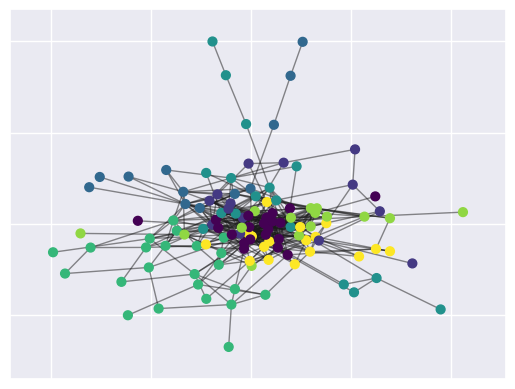

In [37]:
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [44]:
partition = community_louvain.best_partition(G)
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values']).head(3)
partition_lovian

# start to see which variables cluster together.

,Name,Values
0,bact10,0
1,metabolite2,0
2,Bact11,1


In [ ]:
# jsut an exploration , but you can delve much deeper from here